<a href="https://colab.research.google.com/github/ErdemAslans/Autonomous_Driving_Segmentation_Using_ViT_and_SegFormer_with_Enhanced_Attention_Mechanisms/blob/main/Autonomous_Driving_Segmentation_Using_ViT_and_SegFormer_with_Enhanced_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Gerekli kütüphanelerin yüklenmesi
!pip install timm albumentations -q

# Gerekli kütüphanelerin import edilmesi
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Eğer GPU varsa, cihazı ayarla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Klasör yolları
train_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_train'
train_mask_folder = '/content/drive/MyDrive/Images_Otomation/masks/train'
train_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/train'

val_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_val'
val_mask_folder = '/content/drive/MyDrive/Images_Otomation/masks/val'
val_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/val'

# Eşleşen dosyaları işleme ve sayısını bulma
def count_matching_files(image_folder, mask_folder, colormap_folder):
    matching_count = 0  # Eşleşen dosyalar için sayaç
    for image_file in os.listdir(image_folder):
        base_name = os.path.splitext(image_file)[0]

        mask_file = os.path.join(mask_folder, base_name + '.png')
        colormap_file = os.path.join(colormap_folder, base_name + '.png')

        if os.path.exists(mask_file) and os.path.exists(colormap_file):
            matching_count += 1
            print(f"Eşleşen dosya: {image_file}, Mask: {mask_file}, Colormap: {colormap_file}")
        else:
            print(f"Eksik dosya: {base_name}")

    print(f"\nToplam eşleşen dosya sayısı: {matching_count}")
    return matching_count

# Train ve Validation klasörleri için işlemi çağırma
print("Train klasörü için eşleşen dosyalar:")
train_count = count_matching_files(train_image_folder, train_mask_folder, train_colormap_folder)

print("\nValidation klasörü için eşleşen dosyalar:")
val_count = count_matching_files(val_image_folder, val_mask_folder, val_colormap_folder)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Eşleşen dosya: 377f88d4-00000000.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/377f88d4-00000000.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/377f88d4-00000000.png
Eşleşen dosya: 35ab42cd-73f6f6ea.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/35ab42cd-73f6f6ea.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/35ab42cd-73f6f6ea.png
Eşleşen dosya: 4137dec6-a23cdae2.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/4137dec6-a23cdae2.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/4137dec6-a23cdae2.png
Eşleşen dosya: 39fc1bf2-67409f70.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/39fc1bf2-67409f70.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/39fc1bf2-67409f70.png
Eşleşen dosya: 36ae0153-0b30a49b.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/36ae0153-0b30a49b.png, Colorm

In [4]:
def colormap_to_class_labels(colormap, color_to_class):
    labels = np.zeros((colormap.shape[0], colormap.shape[1]), dtype=np.int64)
    for color, label in color_to_class.items():
        mask = np.all(colormap == np.array(color).reshape(1, 1, 3), axis=-1)
        labels[mask] = label
    return labels

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

def colormap_to_class_labels(colormap, color_to_class):
    """
    Colormap görüntüsünü sınıf etiketleri haritasına dönüştürür.

    Args:
        colormap (numpy.ndarray): [H, W, 3] şeklinde RGB colormap.
        color_to_class (dict): RGB renk tuple'larını sınıf indekslerine eşleyen sözlük.

    Returns:
        numpy.ndarray: [H, W] şeklinde sınıf etiketleri.
    """
    labels = np.zeros((colormap.shape[0], colormap.shape[1]), dtype=np.int64)
    for color, label in color_to_class.items():
        mask = np.all(colormap == np.array(color).reshape(1, 1, 3), axis=-1)
        labels[mask] = label
    return labels

class ColormapDataset(Dataset):
    def __init__(self, images_dir, colormaps_dir, color_to_class, transform=None):
        self.images_dir = images_dir
        self.colormaps_dir = colormaps_dir
        self.color_to_class = color_to_class
        self.transform = transform

        # Sadece görüntü ve colormap dosyalarının eşleştiğinden emin olun
        self.matched_files = [
            file for file in os.listdir(images_dir)
            if os.path.exists(os.path.join(colormaps_dir, os.path.splitext(file)[0] + '.png'))
        ]

    def __len__(self):
        return len(self.matched_files)

    def __getitem__(self, idx):
        base_name = self.matched_files[idx]
        image_path = os.path.join(self.images_dir, base_name)
        colormap_path = os.path.join(self.colormaps_dir, os.path.splitext(base_name)[0] + '.png')

        # Görüntü ve colormap yükleme
        image = np.array(Image.open(image_path).convert('RGB')).astype(np.float32) / 255.0
        colormap = np.array(Image.open(colormap_path).convert('RGB'))

        # Colormap'i sınıf etiketlerine dönüştür
        labels = colormap_to_class_labels(colormap, self.color_to_class)

        # Dönüşümleri uygula
        if self.transform:
            augmented = self.transform(image=image, mask=labels)
            image = augmented['image']
            labels = augmented['mask']

        return image, labels

# Albumentations dönüşümleri
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
], additional_targets={'colormap': 'image'})

In [6]:
from torch.utils.data import DataLoader

# Renk-sınıf eşleştirmesi
color_to_class = {
    (128, 64, 128): 0,    # Yol
    (244, 35, 232): 1,    # Kaldırım
    (70, 70, 70): 2,      # Bina
    (102, 102, 156): 3,   # Duvar
    (190, 153, 153): 4,   # Çit
    (153, 153, 153): 5,   # Direk
    (250, 170, 30): 6,    # Trafik Işığı
    (220, 220, 0): 7,     # Trafik Levhası
    (107, 142, 35): 8,    # Bitki Örtüsü
    (152, 251, 152): 9,   # Arazi
    (70, 130, 180): 10,   # Gökyüzü
    (220, 20, 60): 11,    # İnsan
    (255, 0, 0): 12,      # Sürücü
    (0, 0, 142): 13,      # Araba
    (0, 0, 70): 14,       # Kamyon
    (0, 60, 100): 15,     # Otobüs
    (0, 80, 100): 16,     # Tren
    (0, 0, 230): 17,      # Motosiklet
    (119, 11, 32): 18     # Bisiklet
}

# Albumentations dönüşümleri
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

# Train ve Validation dataset'leri
train_dataset = ColormapDataset(train_image_folder, train_colormap_folder, color_to_class, transform=transform)
val_dataset = ColormapDataset(val_image_folder, val_colormap_folder, color_to_class, transform=transform)

# DataLoader'ları tanımla
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)



# Dataset uzunlukları
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

Train dataset length: 7000
Validation dataset length: 1000


In [7]:
class TestImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = np.array(Image.open(image_path).convert('RGB'))

        # Dönüşümü uygula
        if self.transform:
            image = self.transform(image=image)['image']

        return image
# Albumentations dönüşümü
test_transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

# Test dataset ve DataLoader oluşturma
test_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_test'
test_dataset = TestImageDataset(test_image_folder, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

# Test DataLoader'ın hazır olduğuna dair kontrol
print(f"Test dataset length: {len(test_dataset)}")

Test dataset length: 2000


In [8]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import torch

# Klasör yolları
train_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_train'
train_mask_folder = '/content/drive/MyDrive/Images_Otomation/masks/train'
train_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/train'

val_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_val'
val_mask_folder = '/content/drive/MyDrive/Images_Otomation/masks/val'
val_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/val'

# Eşleşen dosyaları işleme ve sayısını bulma
def count_matching_files(image_folder, mask_folder, colormap_folder):
    matching_count = 0  # Eşleşen dosyalar için sayaç
    for image_file in os.listdir(image_folder):
        base_name = os.path.splitext(image_file)[0]

        mask_file = os.path.join(mask_folder, base_name + '.png')
        colormap_file = os.path.join(colormap_folder, base_name + '.png')

        if os.path.exists(mask_file) and os.path.exists(colormap_file):
            matching_count += 1
            print(f"Eşleşen dosya: {image_file}, Mask: {mask_file}, Colormap: {colormap_file}")
        else:
            print(f"Eksik dosya: {base_name}")

    print(f"\nToplam eşleşen dosya sayısı: {matching_count}")
    return matching_count

# Train ve Validation klasörleri için işlemi çağırma
print("Train klasörü için eşleşen dosyalar:")
train_count = count_matching_files(train_image_folder, train_mask_folder, train_colormap_folder)

print("\nValidation klasörü için eşleşen dosyalar:")
val_count = count_matching_files(val_image_folder, val_mask_folder, val_colormap_folder)

# Renk-sınıf eşleştirmesi
color_to_class = {
    (128, 64, 128): 0,    # Yol
    (244, 35, 232): 1,    # Kaldırım
    (70, 70, 70): 2,      # Bina
    (102, 102, 156): 3,   # Duvar
    (190, 153, 153): 4,   # Çit
    (153, 153, 153): 5,   # Direk
    (250, 170, 30): 6,    # Trafik Işığı
    (220, 220, 0): 7,     # Trafik Levhası
    (107, 142, 35): 8,    # Bitki Örtüsü
    (152, 251, 152): 9,   # Arazi
    (70, 130, 180): 10,   # Gökyüzü
    (220, 20, 60): 11,    # İnsan
    (255, 0, 0): 12,      # Sürücü
    (0, 0, 142): 13,      # Araba
    (0, 0, 70): 14,       # Kamyon
    (0, 60, 100): 15,     # Otobüs
    (0, 80, 100): 16,     # Tren
    (0, 0, 230): 17,      # Motosiklet
    (119, 11, 32): 18     # Bisiklet
}

# Colormap to Class Conversion
def colormap_to_class_labels(colormap, color_to_class):
    labels = np.zeros((colormap.shape[0], colormap.shape[1]), dtype=np.int64)
    for color, label in color_to_class.items():
        mask = np.all(colormap == np.array(color).reshape(1, 1, 3), axis=-1)
        labels[mask] = label
    return labels

class ColormapDataset(Dataset):
    def __init__(self, images_dir, colormaps_dir, color_to_class, transform=None):
        self.images_dir = images_dir
        self.colormaps_dir = colormaps_dir
        self.color_to_class = color_to_class
        self.transform = transform

        # Sadece görüntü ve colormap dosyalarının eşleştiğinden emin olun
        self.matched_files = [
            file for file in os.listdir(images_dir)
            if os.path.exists(os.path.join(colormaps_dir, os.path.splitext(file)[0] + '.png'))
        ]

    def __len__(self):
        return len(self.matched_files)

    def __getitem__(self, idx):
        base_name = self.matched_files[idx]
        image_path = os.path.join(self.images_dir, base_name)
        colormap_path = os.path.join(self.colormaps_dir, os.path.splitext(base_name)[0] + '.png')

        # Görüntü ve colormap yükleme
        image = np.array(Image.open(image_path).convert('RGB')).astype(np.float32) / 255.0
        colormap = np.array(Image.open(colormap_path).convert('RGB'))

        # Colormap'i sınıf etiketlerine dönüştür
        labels = colormap_to_class_labels(colormap, self.color_to_class)

        # Dönüşümleri uygula
        if self.transform:
            augmented = self.transform(image=image, mask=labels)
            image = augmented['image']
            labels = augmented['mask']

        return image, labels

# Albumentations dönüşümleri
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

# Train ve Validation dataset'leri için 700/100/200 ayırma
# İlk 700 train, 100 val ve 200 test olacak şekilde küçük bir alt küme oluşturma
train_files, val_files = train_test_split(os.listdir(train_image_folder), train_size=700, random_state=42)
val_files, test_files = train_test_split(val_files, test_size=200, random_state=42)

#Alt kümeyi kullanarak DataLoader tanımlama
train_dataset = ColormapDataset(train_image_folder, train_colormap_folder, color_to_class, transform=transform)
val_dataset = ColormapDataset(val_image_folder, val_colormap_folder, color_to_class, transform=transform)
test_dataset = ColormapDataset(val_image_folder, val_colormap_folder, color_to_class, transform=transform)

# DataLoader'ları oluştur
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# DataLoader'ların hazır olduğuna dair kontrol
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Eşleşen dosya: 39fc1bf2-67409f70.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/39fc1bf2-67409f70.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/39fc1bf2-67409f70.png
Eşleşen dosya: 36ae0153-0b30a49b.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/36ae0153-0b30a49b.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/36ae0153-0b30a49b.png
Eşleşen dosya: 38e7e7de-00000000.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/38e7e7de-00000000.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/38e7e7de-00000000.png
Eşleşen dosya: 33135915-a5699af2.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/33135915-a5699af2.png, Colormap: /content/drive/MyDrive/Images_Otomation/colormaps/train/33135915-a5699af2.png
Eşleşen dosya: 437bc97c-96e7c98c.jpg, Mask: /content/drive/MyDrive/Images_Otomation/masks/train/437bc97c-96e7c98c.png, Colorm

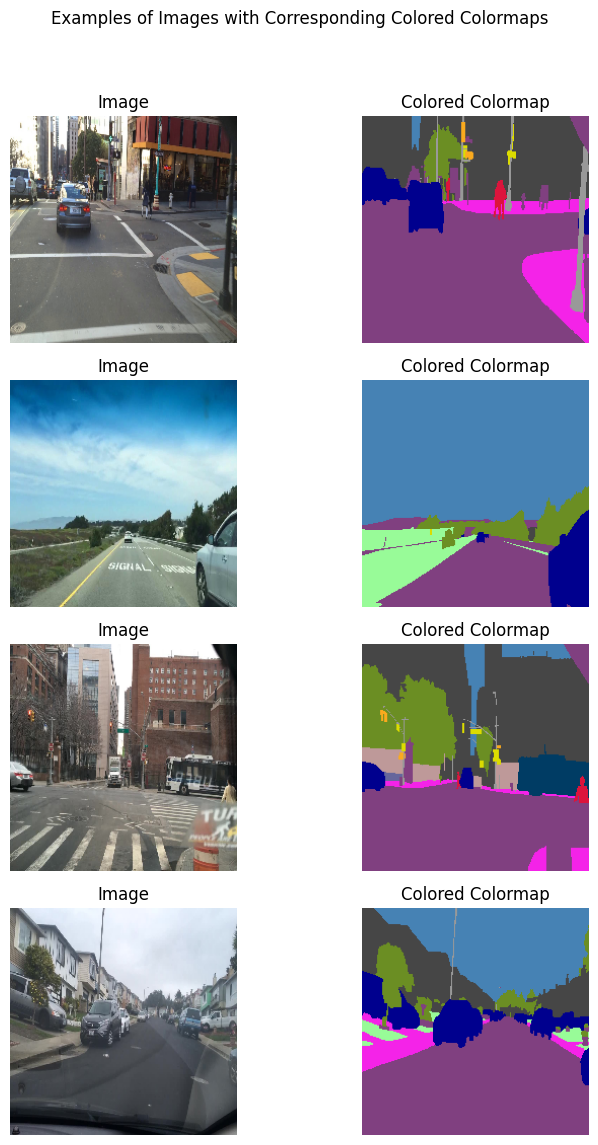

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def apply_color_map(class_map, color_to_class):
    # Sınıf haritası ile aynı boyutlarda RGB renkli harita oluştur
    h, w = class_map.shape
    colored_map = np.zeros((h, w, 3), dtype=np.uint8)

    # color_to_class sözlüğünü tersine çevirerek sınıf numaralarına renkleri atayın
    class_to_color = {v: k for k, v in color_to_class.items()}

    for class_id, color in class_to_color.items():
        # Sınıfa göre piksel seçimi ve renklendirme
        mask = class_map == class_id
        colored_map[mask] = color

    return colored_map

def visualize_colormap_examples(dataloader, color_to_class, num_examples=4):
    data_iter = iter(dataloader)
    images, class_maps = next(data_iter)

    fig, axs = plt.subplots(num_examples, 2, figsize=(8, 12))
    fig.suptitle("Examples of Images with Corresponding Colored Colormaps")

    for i in range(num_examples):
        axs[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())  # (C, H, W) --> (H, W, C)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        # Sınıf haritasını renklendirme ve görselleştirme
        colored_map = apply_color_map(class_maps[i].cpu().numpy(), color_to_class)
        axs[i, 1].imshow(colored_map)  # Renklendirilmiş colormap
        axs[i, 1].set_title("Colored Colormap")
        axs[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Eğitim veri yükleyicisinden örnekleri görselleştir
visualize_colormap_examples(train_dataloader, color_to_class)

In [11]:
!pip install PyWavelets
!pip install bm3d
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # ViT için kullanılacak
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.amp import GradScaler, autocast
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CBAM Attention Mekanizması
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=8):  # Reduction parametresini 8 olarak değiştirdik
        super(CBAMBlock, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa)
        x = x * sa

        return x

# Multi-Scale Feature Fusion (FPN stili)
class MultiScaleFeatureFusion(nn.Module):
    def __init__(self, embed_dim, dropout_rate=0.3):  # Dropout oranını 0.3 olarak güncelledik
        super(MultiScaleFeatureFusion, self).__init__()
        self.conv1 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # Konvolüsyon katmanlarını uygula
        x1 = F.interpolate(
            self.conv1(x),
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        x2 = self.conv2(x)
        x3 = F.interpolate(
            self.conv3(x),
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )

        # Özellikleri birleştir
        fused = x1 + x2 + x3
        fused = self.dropout(fused)
        return fused  # [batch_size, 384, 224, 224]

# ViT Feature Extractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, drop_rate=dropout_rate, drop_path_rate=0.2)
        self.vit.head = nn.Identity()  # Classification head'i kaldır
        self.embed_dim = self.vit.embed_dim  # örn., 768 for ViT Base

    def forward(self, x):
        x = self.vit.forward_features(x)  # [B, num_patches + 1, embed_dim]
        return x

# SegFormer Decoder with Attention
class SegFormerDecoderWithAttention(nn.Module):
    def __init__(self, embed_dim, num_classes=19, patch_size=16, dropout_rate=0.4):
        super(SegFormerDecoderWithAttention, self).__init__()
        self.patch_size = patch_size
        self.num_patches_side = 224 // self.patch_size  # 14
        self.linear_fuse = nn.Linear(embed_dim, embed_dim)

        # Sadece colormap için tahmin başlığı
        self.conv_pred_colormap = nn.Conv2d(embed_dim // 2, num_classes, kernel_size=1)

        self.dropout = nn.Dropout(p=dropout_rate)

        # CBAM Attention
        self.cbam = CBAMBlock(embed_dim, reduction=8)  # Güncellenmiş reduction değeri
        # Multi-Scale Feature Fusion
        self.multi_scale_fusion = MultiScaleFeatureFusion(embed_dim, dropout_rate=0.3)  # Güncellenmiş dropout değeri

        # Ağırlıkları başlat
        nn.init.kaiming_normal_(self.linear_fuse.weight)
        nn.init.kaiming_normal_(self.conv_pred_colormap.weight)

    def forward(self, x):
        x = x[:, 1:, :]  # CLS token'ını çıkar
        x = self.linear_fuse(x)
        x = x.transpose(1, 2).contiguous().view(-1, x.size(2), self.num_patches_side, self.num_patches_side)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.cbam(x)
        x = self.multi_scale_fusion(x)

        # Sadece colormap tahmini
        colormap_output = self.conv_pred_colormap(x)
        return colormap_output

class ViT_SegFormer_Model(nn.Module):
    def __init__(self, dropout_rate=0.3, num_classes=19):
        super(ViT_SegFormer_Model, self).__init__()
        self.vit = ViTFeatureExtractor(dropout_rate)
        self.decoder = SegFormerDecoderWithAttention(embed_dim=self.vit.embed_dim, num_classes=num_classes, dropout_rate=dropout_rate)

    def forward(self, x):
        features = self.vit(x)
        colormap_output = self.decoder(features)
        return colormap_output

# Model tanımı ve eğitimi
model = ViT_SegFormer_Model(dropout_rate=0.3).to(device)

# ViT kısmındaki önceden eğitilmiş ağırlıkları donduruyoruz
for param in model.vit.parameters():
    param.requires_grad = False

# Optimizasyon ve öğrenme oranı planlaması
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.cuda.amp import GradScaler, autocast  # Correct import
import matplotlib.pyplot as plt
import numpy as np
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Softmax aktivasyon uygulanır
        inputs = F.softmax(inputs, dim=1)

        # One-hot encoding yapılır
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        # Flatten işlemi
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        targets = targets.view(targets.size(0), targets.size(1), -1)

        # Dice katsayısı hesaplama
        intersection = (inputs * targets).sum(-1)
        dice_coeff = (2. * intersection + self.smooth) / (inputs.sum(-1) + targets.sum(-1) + self.smooth)
        dice_loss = 1 - dice_coeff.mean()

        return dice_loss

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Softmax aktivasyon uygulanır
        inputs = F.softmax(inputs, dim=1)

        # One-hot encoding yapılır
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        # Flatten işlemi
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        targets = targets.view(targets.size(0), targets.size(1), -1)

        # IoU hesaplama
        intersection = (inputs * targets).sum(-1)
        total = (inputs + targets).sum(-1)
        union = total - intersection

        iou = (intersection + self.smooth) / (union + self.smooth)
        iou_loss = 1 - iou.mean()

        return iou_loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        # Sigmoid işlemi içermeyen binary_cross_entropy_with_logits kullanılıyor
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()
class BoundaryLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(BoundaryLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Softmax uygulanmış değerler üzerinden işlem yapacağız
        inputs = F.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        boundary_loss = 0.0
        for c in range(inputs.shape[1]):
            # Her bir kanal için kenar tespiti yap
            grad_inputs = torch.sqrt(F.conv2d(inputs[:, c:c+1], torch.ones((1, 1, 3, 3), device=inputs.device), padding=1) ** 2)
            grad_targets = torch.sqrt(F.conv2d(targets[:, c:c+1], torch.ones((1, 1, 3, 3), device=targets.device), padding=1) ** 2)

            # Kenar tespiti sonuçlarını karşılaştırarak kayıp hesapla
            intersection = (grad_inputs * grad_targets).sum()
            union = grad_inputs.sum() + grad_targets.sum()
            boundary_loss += 1 - (2. * intersection + self.smooth) / (union + self.smooth)

        return boundary_loss / inputs.shape[1]  # Her kanal için ortalama alın

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.2, iou_weight=0.2, focal_weight=0.3, boundary_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.iou_loss = IoULoss()
        self.focal_loss = FocalLoss()
        self.boundary_loss = BoundaryLoss()

        self.dice_weight = dice_weight
        self.iou_weight = iou_weight
        self.focal_weight = focal_weight
        self.boundary_weight = boundary_weight

    def forward(self, outputs, targets):
        dice = self.dice_loss(outputs, targets)
        iou = self.iou_loss(outputs, targets)
        focal = self.focal_loss(outputs, targets)
        boundary = self.boundary_loss(outputs, targets)

        total_loss = (self.dice_weight * dice +
                      self.iou_weight * iou +
                      self.focal_weight * focal +
                      self.boundary_weight * boundary)
        return total_loss


# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model tanımı ve eğitimi
model = ViT_SegFormer_Model(dropout_rate=0.2).to(device)

# Tüm parametreleri eğitilebilir yap
for param in model.parameters():
    param.requires_grad = True

# Kayıp fonksiyonunu tanımla
loss_fn = CombinedLoss(dice_weight=0.2, iou_weight=0.2, focal_weight=0.3, boundary_weight=0.3).to(device)


# Optimizer ve Scheduler
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

# Eğitim ve doğrulama metriklerini takip etmek için listeler
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_recalls, val_recalls = [], []
train_iou_scores, val_iou_scores = [], []
train_dice_scores, val_dice_scores = [], []


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, num_epochs=30, accumulation_steps=4):
    scaler = GradScaler()
    best_val_loss = float('inf')
    patience = 10  # Erken durdurma sabrı
    trigger_times = 0

    # Eğitim ve doğrulama metriklerini takip etmek için listeler
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []
    train_recalls, val_recalls = [], []
    train_iou_scores, val_iou_scores = [], []
    train_dice_scores, val_dice_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_f1 = 0.0
        running_accuracy = 0.0
        running_recall = 0.0
        running_iou = 0.0
        running_dice = 0.0

        optimizer.zero_grad()  # Gradient'leri sıfırla

        for batch_idx, (images, colormaps) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")):
            # Veriyi cihaza taşı
            images = images.float().to(device)
            colormaps = colormaps.long().to(device)  # Sınıf etiketleri için long tipinde

            # Her epoch'un ilk batch'inde şekilleri yazdır
            if batch_idx == 0:
                print(f"\nEpoch {epoch+1}, Batch {batch_idx+1}:")
                print(f"  Images shape: {images.shape}")       # [B, 3, 224, 224]
                print(f"  Colormaps shape: {colormaps.shape}") # [B, 224, 224]

            with autocast(enabled=True):
                outputs = model(images)  # [B, num_classes, 224, 224]
                loss = loss_fn(outputs, colormaps)  # DiceIoULoss
                loss = loss / accumulation_steps  # Normalize loss

            scaler.scale(loss).backward()

            # Gradient birikimi
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)  # Gradient'leri geri ölçeklendir
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Gradient'leri sıfırla

            running_loss += loss.item() * accumulation_steps  # Loss'u biriktir

            # Metrikleri hesapla
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]
            preds_flat = preds.view(-1).cpu().numpy()
            colormaps_flat = colormaps.view(-1).cpu().numpy()

            recall = recall_score(colormaps_flat, preds_flat, average='macro', zero_division=0)
            f1 = f1_score(colormaps_flat, preds_flat, average='macro', zero_division=0)
            accuracy = accuracy_score(colormaps_flat, preds_flat)

            # IoU ve Dice hesaplamaları çok sınıflı segmentasyon için iyileştirilebilir
            # Basit bir örnek olarak tüm sınıflar için ortak IoU ve Dice
            intersection = np.logical_and(preds_flat, colormaps_flat).sum()
            union = np.logical_or(preds_flat, colormaps_flat).sum()
            iou = (intersection + 1e-6) / (union + 1e-6)
            dice = (2 * intersection + 1e-6) / (preds_flat.sum() + colormaps_flat.sum() + 1e-6)

            running_recall += recall
            running_f1 += f1
            running_accuracy += accuracy
            running_iou += iou
            running_dice += dice

        # Epoch için ortalama metrikleri hesapla
        avg_loss = running_loss / len(train_loader)
        avg_f1 = running_f1 / len(train_loader)
        avg_accuracy = running_accuracy / len(train_loader)
        avg_recall = running_recall / len(train_loader)
        avg_iou = running_iou / len(train_loader)
        avg_dice = running_dice / len(train_loader)

        train_losses.append(avg_loss)
        train_f1_scores.append(avg_f1)
        train_accuracies.append(avg_accuracy)
        train_recalls.append(avg_recall)
        train_iou_scores.append(avg_iou)
        train_dice_scores.append(avg_dice)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Recall: {avg_recall:.4f}, "
              f"F1 Score: {avg_f1:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")

        # Doğrulama aşaması
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0
        val_accuracy = 0.0
        val_recall = 0.0
        val_iou = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, colormaps in tqdm(val_loader, desc="Validating"):
                images = images.float().to(device)
                colormaps = colormaps.long().to(device)

                outputs = model(images)  # [B, num_classes, 224, 224]
                loss = loss_fn(outputs, colormaps)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)  # [B, H, W]
                preds_flat = preds.view(-1).cpu().numpy()
                colormaps_flat = colormaps.view(-1).cpu().numpy()

                recall = recall_score(colormaps_flat, preds_flat, average='macro', zero_division=0)
                f1 = f1_score(colormaps_flat, preds_flat, average='macro', zero_division=0)
                accuracy = accuracy_score(colormaps_flat, preds_flat)

                intersection = np.logical_and(preds_flat, colormaps_flat).sum()
                union = np.logical_or(preds_flat, colormaps_flat).sum()
                iou = (intersection + 1e-6) / (union + 1e-6)
                dice = (2 * intersection + 1e-6) / (preds_flat.sum() + colormaps_flat.sum() + 1e-6)

                val_recall += recall
                val_f1 += f1
                val_accuracy += accuracy
                val_iou += iou
                val_dice += dice

        # Doğrulama metriklerini ortalamala
        avg_val_loss = val_loss / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        val_losses.append(avg_val_loss)
        val_f1_scores.append(avg_val_f1)
        val_accuracies.append(avg_val_accuracy)
        val_recalls.append(avg_val_recall)
        val_iou_scores.append(avg_val_iou)
        val_dice_scores.append(avg_val_dice)

        print(f"Validation Loss: {avg_val_loss:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, "
              f"Accuracy: {avg_val_accuracy:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")

        # Scheduler güncelle
        scheduler.step(avg_val_loss)

        # En iyi modeli kaydet ve erken durdurmayı uygula
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Yeni en iyi model kaydedildi (Validation Loss: {best_val_loss:.4f})")
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Erken durdurma tetiklendi")
                break

        # GPU belleğini temizle
        del images, colormaps, outputs, loss
        torch.cuda.empty_cache()

# Eğitim sonrası metrikleri görselleştirme
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(24, 6))

    # Kayıp grafiği
    plt.subplot(1, 6, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk grafiği
    plt.subplot(1, 6, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Skoru grafiği
    plt.subplot(1, 6, 3)
    plt.plot(epochs, train_f1_scores, label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Recall grafiği
    plt.subplot(1, 6, 4)
    plt.plot(epochs, train_recalls, label='Training Recall')
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # IoU grafiği
    plt.subplot(1, 6, 5)
    plt.plot(epochs, train_iou_scores, label='Training IoU')
    plt.plot(epochs, val_iou_scores, label='Validation IoU')
    plt.title('IoU over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Dice grafiği
    plt.subplot(1, 6, 6)
    plt.plot(epochs, train_dice_scores, label='Training Dice')
    plt.plot(epochs, val_dice_scores, label='Validation Dice')
    plt.title('Dice over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Modeli eğitme ve performansı izleme
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, num_epochs=25)


# Eğitim sonrası metrikleri görselleştirme
plot_metrics()




<ipython-input-6-2724279f8e59>:170: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 1, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 1/25 - Training:   5%|▍         | 1/22 [01:53<39:36, 113.16s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 1/25 - Training:   9%|▉         | 2/22 [01:55<15:59, 47.96s/it] <ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 1/25 - Training:  14%|█▎        | 3/22 [01:58<08:37, 27.23s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 1/25 - Training:  18%|█▊ 

Epoch 1/25, Training Loss: 0.6950, Recall: 0.0460, F1 Score: 0.0219, Accuracy: 0.0540, IoU: 0.5859, Dice: 0.0767


Validating: 100%|██████████| 4/4 [00:47<00:00, 11.82s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759
Yeni en iyi model kaydedildi (Validation Loss: 0.7028)


Epoch 2/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 2, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 2/25 - Training:   5%|▍         | 1/22 [00:20<07:01, 20.07s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 2/25 - Training:   9%|▉         | 2/22 [00:22<03:16,  9.82s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 2/25 - Training:  14%|█▎        | 3/22 [00:25<02:03,  6.52s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 2/25 - Training:  18%|█▊   

Epoch 2/25, Training Loss: 0.6941, Recall: 0.0461, F1 Score: 0.0224, Accuracy: 0.0551, IoU: 0.5863, Dice: 0.0773


Validating: 100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 3/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 3, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 3/25 - Training:   5%|▍         | 1/22 [00:19<06:58, 19.91s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 3/25 - Training:   9%|▉         | 2/22 [00:23<03:26, 10.30s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 3/25 - Training:  14%|█▎        | 3/22 [00:26<02:12,  6.98s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 3/25 - Training:  18%|█▊   

Epoch 3/25, Training Loss: 0.6899, Recall: 0.0478, F1 Score: 0.0244, Accuracy: 0.0594, IoU: 0.5872, Dice: 0.0771


Validating: 100%|██████████| 4/4 [00:22<00:00,  5.73s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 4/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 4, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 4/25 - Training:   5%|▍         | 1/22 [00:19<06:59, 19.96s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 4/25 - Training:   9%|▉         | 2/22 [00:23<03:22, 10.12s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 4/25 - Training:  14%|█▎        | 3/22 [00:25<02:06,  6.68s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 4/25 - Training:  18%|█▊   

Epoch 4/25, Training Loss: 0.6912, Recall: 0.0466, F1 Score: 0.0239, Accuracy: 0.0575, IoU: 0.5886, Dice: 0.0776


Validating: 100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 5/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 5, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 5/25 - Training:   5%|▍         | 1/22 [00:20<07:12, 20.61s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 5/25 - Training:   9%|▉         | 2/22 [00:23<03:23, 10.20s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 5/25 - Training:  14%|█▎        | 3/22 [00:25<02:06,  6.67s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 5/25 - Training:  18%|█▊   

Epoch 5/25, Training Loss: 0.6946, Recall: 0.0438, F1 Score: 0.0222, Accuracy: 0.0554, IoU: 0.5864, Dice: 0.0771


Validating: 100%|██████████| 4/4 [00:23<00:00,  5.76s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 6/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 6, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 6/25 - Training:   5%|▍         | 1/22 [00:20<07:01, 20.05s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 6/25 - Training:   9%|▉         | 2/22 [00:22<03:19,  9.97s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 6/25 - Training:  14%|█▎        | 3/22 [00:25<02:04,  6.55s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 6/25 - Training:  18%|█▊   

Epoch 6/25, Training Loss: 0.6941, Recall: 0.0473, F1 Score: 0.0226, Accuracy: 0.0564, IoU: 0.5871, Dice: 0.0772


Validating: 100%|██████████| 4/4 [00:22<00:00,  5.75s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 7/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 7, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 7/25 - Training:   5%|▍         | 1/22 [00:20<07:19, 20.91s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 7/25 - Training:   9%|▉         | 2/22 [00:24<03:32, 10.65s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 7/25 - Training:  14%|█▎        | 3/22 [00:26<02:11,  6.92s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 7/25 - Training:  18%|█▊   

Epoch 7/25, Training Loss: 0.6933, Recall: 0.0470, F1 Score: 0.0228, Accuracy: 0.0566, IoU: 0.5872, Dice: 0.0771


Validating: 100%|██████████| 4/4 [00:23<00:00,  5.79s/it]


Validation Loss: 0.7028, Recall: 0.0488, F1 Score: 0.0122, Accuracy: 0.0423, IoU: 0.6129, Dice: 0.0759


Epoch 8/25 - Training:   0%|          | 0/22 [00:00<?, ?it/s]


Epoch 8, Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Colormaps shape: torch.Size([32, 224, 224])


<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 8/25 - Training:   5%|▍         | 1/22 [00:20<07:19, 20.93s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 8/25 - Training:   9%|▉         | 2/22 [00:23<03:27, 10.40s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 8/25 - Training:  14%|█▎        | 3/22 [00:26<02:09,  6.82s/it]<ipython-input-6-2724279f8e59>:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 8/25 - Training:  18%|█▊   

KeyboardInterrupt: 

AttributeError: 'list' object has no attribute 'ndim'

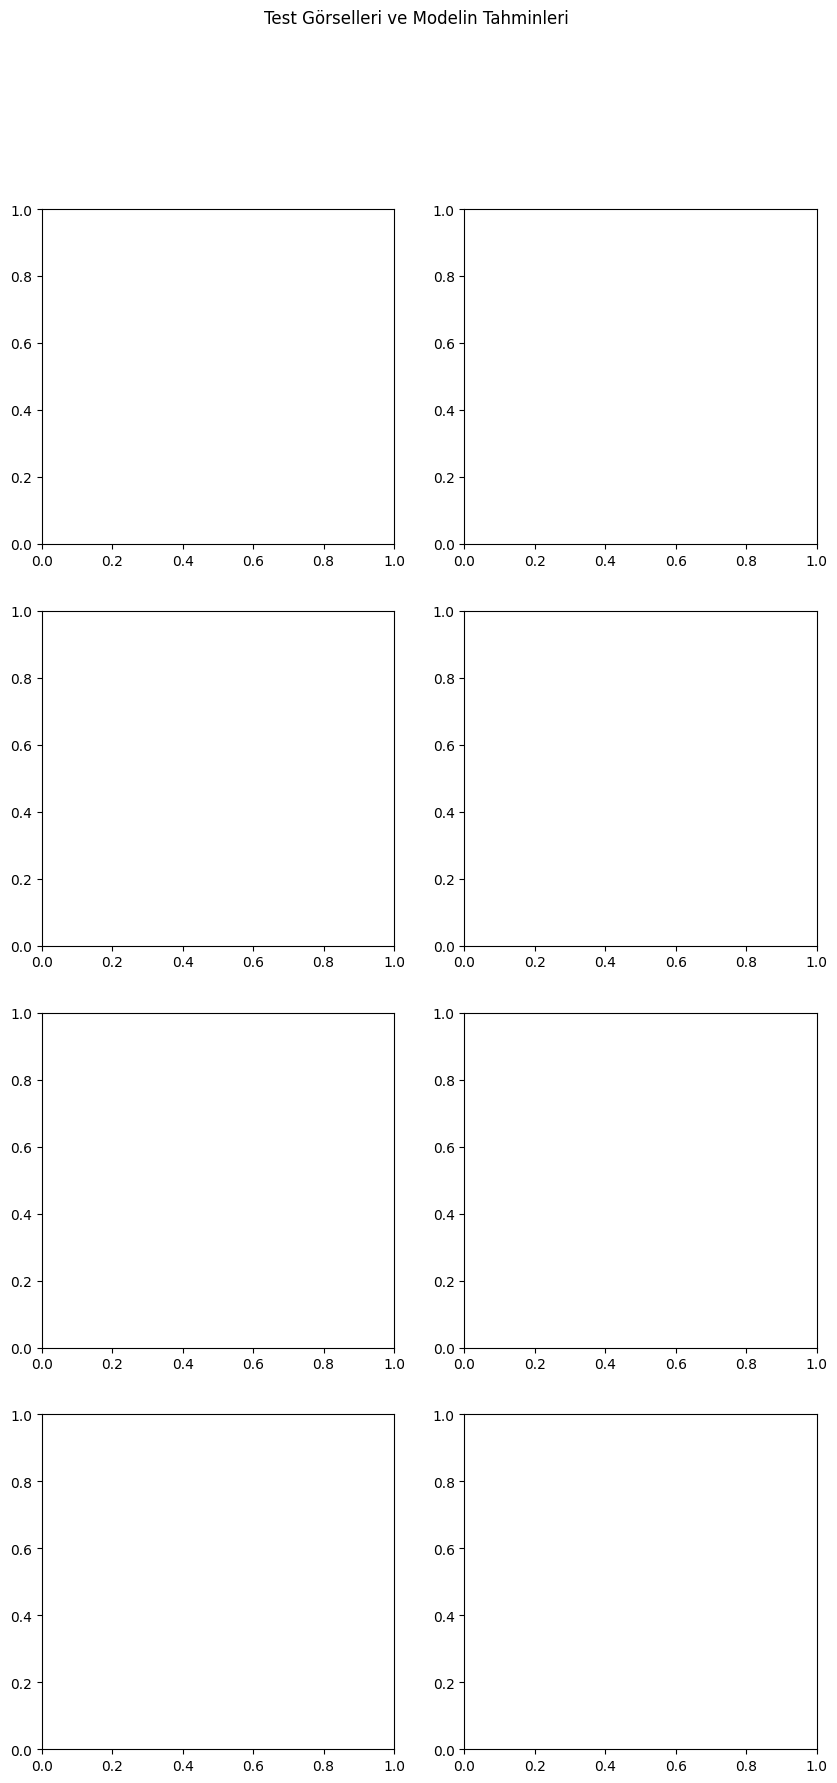

In [ ]:
import matplotlib.pyplot as plt
import torch
from monai.transforms import AsDiscrete

def test_model_with_visualization(model, test_loader, device, color_to_class):
    model.eval()
    post_trans = AsDiscrete(threshold=0.5)  # Model çıktısını ikili hale getirme

    fig, axs = plt.subplots(4, 2, figsize=(10, 20))
    fig.suptitle("Test Görselleri ve Modelin Tahminleri")

    with torch.no_grad():
        for idx, images in enumerate(test_loader):
            if idx >= 4:  # Sadece 4 örnek gösterelim
                break

            # Eğer tek kanallı ise, 3 kanala dönüştür
            if images.ndim == 3:
                images = images.unsqueeze(1)
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            images = images.float().to(device)

            # Modelin tahminleri
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]

            # Görsel ve tahminlerin görselleştirilmesi
            for i in range(min(len(images), 1)):  # Sadece ilk resmi gösterelim
                # Orijinal görüntüyü [0, 1] aralığına ölçeklendir
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

                # Orijinal görüntüyü göster
                axs[idx, 0].imshow(img)
                axs[idx, 0].set_title("Original Image")
                axs[idx, 0].axis("off")

                # Model tahminini renklendirerek göster
                colormap_prediction = apply_color_map(outputs[i], color_to_class)
                axs[idx, 1].imshow(colormap_prediction)
                axs[idx, 1].set_title("Predicted Colormap")
                axs[idx, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Test verisi ve modeli değerlendir
test_model_with_visualization(model, test_dataloader, device, color_to_class)

In [ ]:
# Visualize predictions on test dataset
visualize_test_predictions(model, test_dataloader, color_to_class, device, num_examples=4)


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

ViTFeatureExtractor Input: torch.Size([32, 224, 224])


Testing:   0%|          | 0/63 [00:19<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 3)